In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from texttable import Texttable
from latextable import draw_latex

# Rust - power efficiency
## Import data

In [36]:
def read_json(file_name):
  with open(file_name, "r") as f:
    data = json.load(f)

  goose_df = pd.DataFrame(data["rps"], columns=["date", "rps"])
  goose_df["power"] = data["power"]
  goose_df["power"] = goose_df["power"].apply(lambda x: x / 10)
  goose_df = goose_df[(goose_df.rps > 1000)]

  goose_df.head()
  
  return goose_df

quarkus_full_power = read_json("quarkus_full_power.json")
quarkus_power_eff = read_json("quarkus_per_eff.json")

rust_full_power = read_json("rust_full_power.json")
rust_power_eff = read_json("rust_power_eff.json")

# avg & mean values

In [47]:
t = Texttable()
t.add_rows([['', 'Quarkus fp', 'Rust fp', 'Quarkus pe', 'Rust pe'],
            ['power mean', quarkus_full_power.power.mean(), rust_full_power.power.mean(), quarkus_power_eff.power.mean(), rust_power_eff.power.mean()],
            ['rps mean', quarkus_full_power.rps.mean(), rust_full_power.rps.mean(), quarkus_power_eff.rps.mean(), rust_power_eff.rps.mean()],
            ['req / w', quarkus_full_power.rps.mean()/quarkus_full_power.power.mean(), rust_full_power.rps.mean()/rust_full_power.power.mean(),
              quarkus_power_eff.rps.mean()/quarkus_power_eff.power.mean(), rust_power_eff.rps.mean()/rust_power_eff.power.mean()],
            ['req / w over base', quarkus_full_power.rps.mean()/(quarkus_full_power.power.mean()-36), rust_full_power.rps.mean()/(rust_full_power.power.mean()-36),
              quarkus_power_eff.rps.mean()/(quarkus_power_eff.power.mean()-36), rust_power_eff.rps.mean()/(rust_power_eff.power.mean()-36)]
          ])
print(t.draw())
print(draw_latex(t))

+------------+------------+----------+------------+----------+
|            | Quarkus fp | Rust fp  | Quarkus pe | Rust pe  |
+============+============+==========+============+==========+
| power mean | 83.944     | 71.636   | 53.090     | 45.400   |
+------------+------------+----------+------------+----------+
| rps mean   | 4254.262   | 5870.205 | 1772.847   | 1781.932 |
+------------+------------+----------+------------+----------+
| req / w    | 50.680     | 81.945   | 33.393     | 39.249   |
+------------+------------+----------+------------+----------+
\begin{table}
	\begin{center}
		\begin{tabular}{|l|l|l|l|l|}
			\hline
			 & Quarkus fp & Rust fp & Quarkus pe & Rust pe \\
			\hline
			power mean & 83.944 & 71.636 & 53.090 & 45.400 \\
			\hline
			rps mean & 4254.262 & 5870.205 & 1772.847 & 1781.932 \\
			\hline
			req / w & 50.680 & 81.945 & 33.393 & 39.249 \\
			\hline
		\end{tabular}
	\end{center}
\end{table}


In [38]:
# std deviation

t = Texttable()
t.add_rows([['', 'Quarkus fp', 'Rust fp', 'Quarkus pe', 'Rust pe'],
            ['power std', np.std(quarkus_full_power.power), np.std(rust_full_power.power), np.std(quarkus_power_eff.power), np.std(rust_power_eff.power)],
            ['rps std', np.std(quarkus_full_power.rps), np.std(rust_full_power.rps), np.std(quarkus_power_eff.rps), np.std(rust_power_eff.rps)]])
print(t.draw())
print(draw_latex(t))


+-----------+------------+---------+------------+---------+
|           | Quarkus fp | Rust fp | Quarkus pe | Rust pe |
+===========+============+=========+============+=========+
| power std | 1.912      | 1.979   | 0.839      | 0.744   |
+-----------+------------+---------+------------+---------+
| rps std   | 139.359    | 274.735 | 10.264     | 9.134   |
+-----------+------------+---------+------------+---------+
\begin{table}
	\begin{center}
		\begin{tabular}{|l|l|l|l|l|}
			\hline
			 & Quarkus fp & Rust fp & Quarkus pe & Rust pe \\
			\hline
			power std & 1.912 & 1.979 & 0.839 & 0.744 \\
			\hline
			rps std & 139.359 & 274.735 & 10.264 & 9.134 \\
			\hline
		\end{tabular}
	\end{center}
\end{table}


## create graph

In [39]:
def plot_graph(df):
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  line1 = ax1.plot(df.index, df.rps, label="Requests each second", linewidth=0.9)
  ax1.set_ylim([df.rps.min() - 500, df.rps.max() + 150])
  ax1.set_ylabel("Requests")

  line2 = ax2.plot(df.index, df.power, 'r', label="Power draw", linewidth=0.9)
  ax2.set_ylim([df.power.mean() - 30, df.power.max() + 30])
  ax2.set_ylabel("Watts")
  
  lns = line1+line2
  labels = [l.get_label() for l in lns]
  leg = ax1.legend(lns, labels, loc=0)
  
  for line in leg.get_lines():
    line.set_linewidth(3)
    
  ax1.set_xlabel("Seconds during benchmark")

  fig.set_dpi(150)

  plt.show()

In [40]:
def plot_compare_graph(df1, df2, desc1_1, desc1_2, desc2_1, desc2_2):
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  line1_1 = ax1.plot(df1.index, df1.rps, "royalblue",label=desc1_1, linewidth=0.7)
  line1_2 = ax1.plot(df2.index, df2.rps, "orangered", label=desc1_2, linewidth=0.7)
  
  # configure limits
  
  if df1.rps.max() > df2.rps.max():
    ymax = df1.rps.max() + 700
  else:
    ymax =df2.rps.max() + 700
    
  if df1.rps.min() < df2.rps.min():
    ymin = df1.rps.min() - 200
  else:
    ymin = df2.rps.min() - 200
  
  ax1.set_ylim([ymin, ymax])
  
  ax1.set_ylabel("Requests")
  
  line2_1 = ax2.plot(df1.index, df1.power, "darkturquoise", label=desc2_1, linewidth=0.7)
  line2_2 = ax2.plot(df2.index, df2.power, "orange", label=desc2_2, linewidth=0.7)
  
  # configure limits
  
  if df1.power.max() > df2.power.max():
    ymax = df1.power.max() + 30
  else:
    ymax =df2.power.max() + 30
    
  if df1.power.min() < df2.power.min():
    ymin = df1.power.mean() - 30
  else:
    ymin = df2.power.mean() - 30
  
  ax2.set_ylim([ymin, ymax])
  ax2.set_ylabel("Watts")
  
  lns = line1_1+line2_1+line1_2+line2_2
  labels = [l.get_label() for l in lns]
  
  leg = ax1.legend(lns, labels, loc=0)
  
  for line in leg.get_lines():
    line.set_linewidth(3)
  
  ax1.set_xlabel("Seconds during benchmark")

  fig.set_dpi(150)

  plt.show()

# render graphs
## 

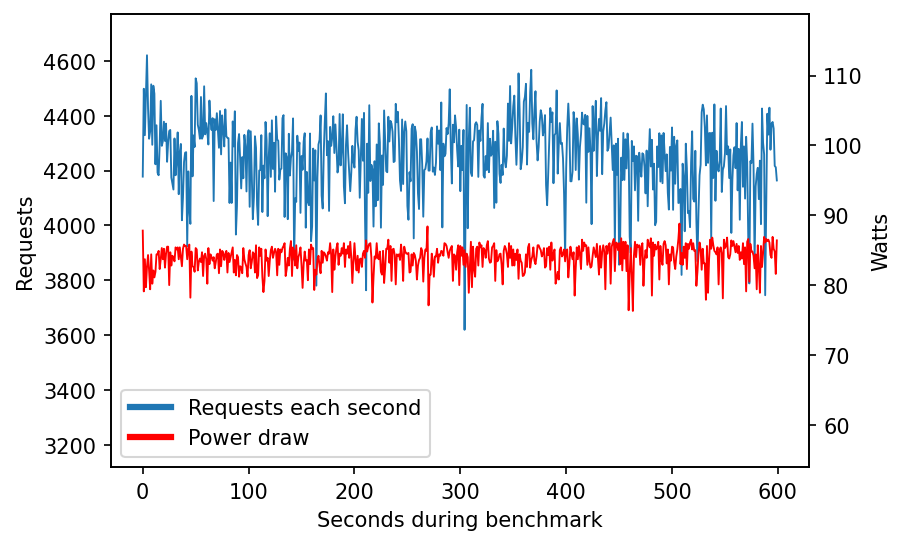

In [41]:
plot_graph(quarkus_full_power)


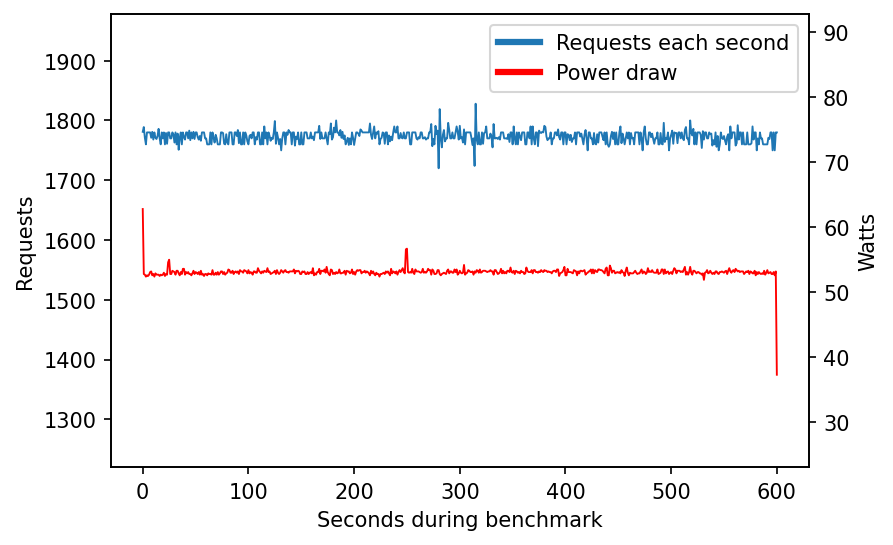

In [42]:
plot_graph(quarkus_power_eff)

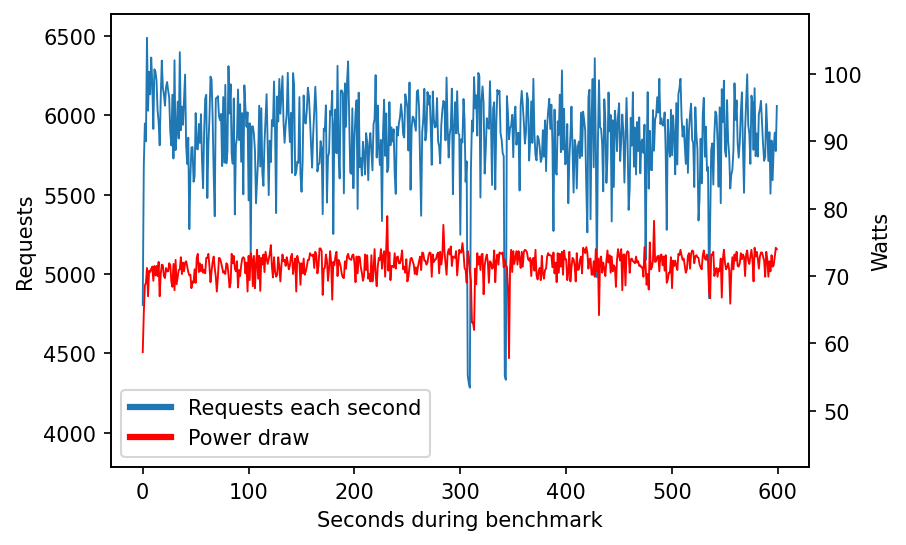

In [43]:
plot_graph(rust_full_power)

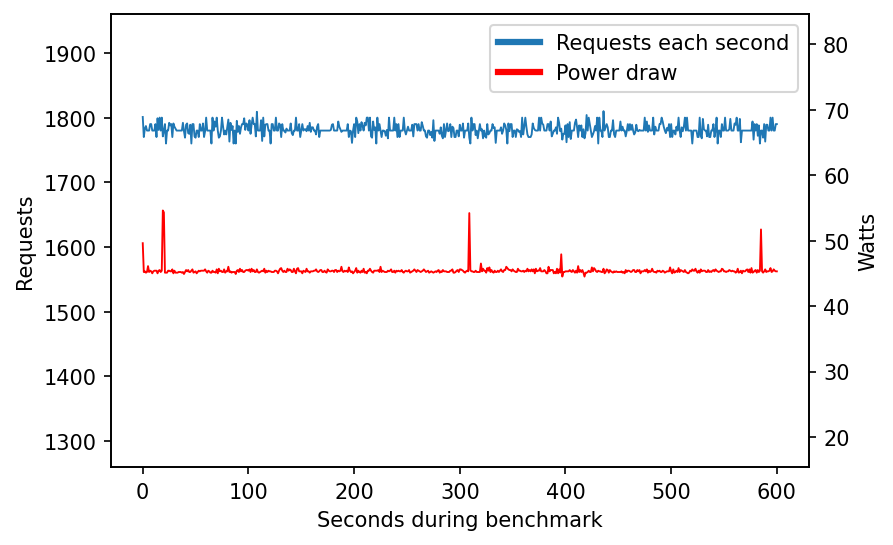

In [44]:
plot_graph(rust_power_eff)

# comparison graphs

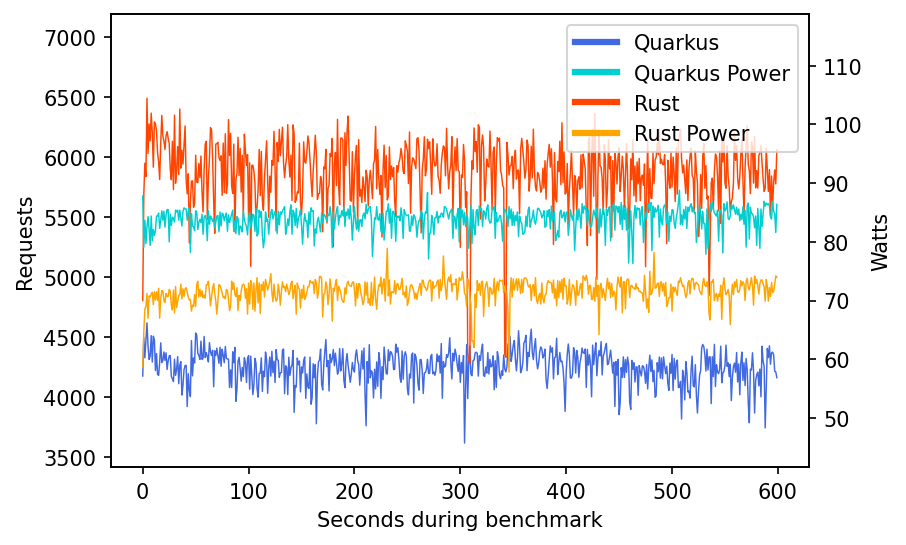

In [45]:
plot_compare_graph(quarkus_full_power, rust_full_power, "Quarkus", "Rust", "Quarkus Power", "Rust Power")